## Image Inpainting with Image网

We'd like to make use of the [Image网 dataset](https://github.com/fastai/imagenette/blob/master/README.md). My understanding is that it doesn't have labels so it would make sense to use as a dataset for our pretext tasks

Once again our pretext task will be cutting patches out of images and having our neural network fill in the missing pieces. In this approach we use a U-Net and have the network generate the entire input image (including the pieces that are not missing).

In [1]:
import json
import torch
import numpy as np

from config import config
from RandomCutout import RandomCutout, PILImageInput

from fastai2.basics import *
from fastai2.vision.all import *

from torch.nn import MSELoss
from functools import partial

We will train this network with the best hyper-parameters/optimizer/settings we know. These settings come from [training Imagenette](https://github.com/fastai/imagenette/tree/58a63175a2c6457650289d32741940d6a7d58fbf). 

One thing to keep in mind is that the above is a classification task, so it's not 100% guaranteed that these settings will map perfectly to our task. That said, they're probably a very good starting point.

In [2]:
# Default parameters
lr=config['lr']
size=config['size']
sqrmom=config['sqrmom']
mom=config['mom']
eps=config['eps']
epochs=config['epochs']
bs=config['bs']
opt=config['opt']
sh=config['sh']
sa=config['sa']
sym=config['sym']
beta=config['beta']
act_fn=config['act_fn']
fp16=config['fp16']
pool=config['pool'],
runs=config['runs']

model = config['model']

if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

# Default parameters
print("lr", lr)
print("size", size)
print("sqrmom", sqrmom)
print("mom", mom)
print("eps", eps)
print("epochs", epochs)
print("bs", bs)
print("opt", opt)
print("sh", sh)
print("sa", sa)
print("sym", sym)
print("beta", beta)
print("act_fn", act_fn)
print("fp16", fp16)
print("pool", pool)
print("runs", runs)
print("model", model)

lr 0.008
size 128
sqrmom 0.99
mom 0.9
eps 1e-06
epochs 15
bs 64
opt ranger
sh 0.0
sa 0
sym 0
beta 0.0
act_fn <class 'fastai2.layers.Mish'>
fp16 0
pool (<function MaxPool at 0x7fde361deef0>,)
runs 1
model <function xresnet34 at 0x7fde35fee950>


In [3]:
def get_dbunch(size, bs):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5), RandomCutout]
    batch_tfms=[RandomErasing(p=0.9, max_count=3, sh=sh), Normalize] if sh else None
    
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, 
                       get_y=lambda o: o,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)

    workers = min(8, num_cpus())
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [4]:
dbunch = get_dbunch(size, bs)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

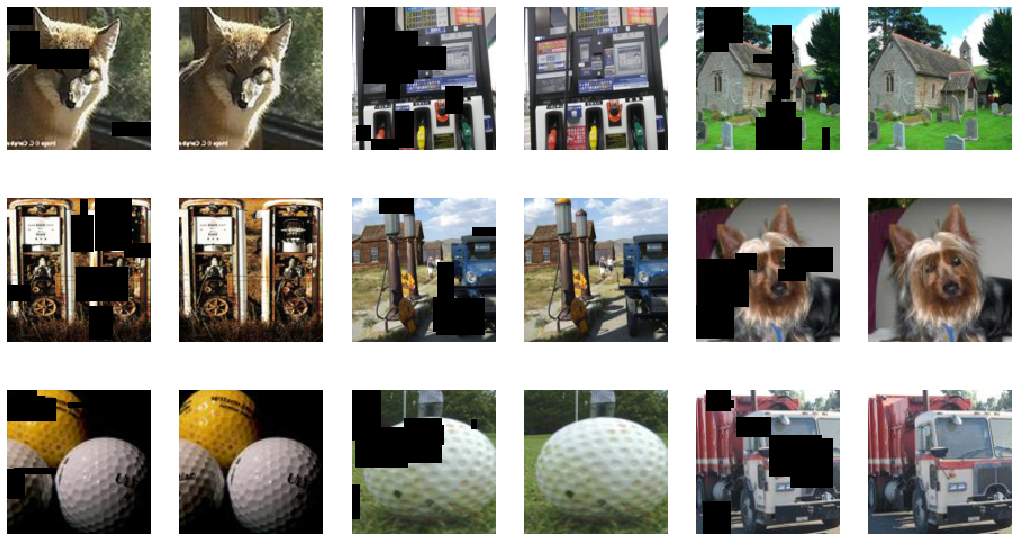

In [5]:
dbunch.show_batch()

In [6]:
class PlotResultsAfterEpoch(Callback):
    "`Callback` that plots the predictions after every epoch"
    def __init__(self, num_images=4):
        self.num_images = num_images
    
    def after_epoch(self):
        preds, targs = to_detach(self.pred),to_detach(self.yb)
        
        print("Epoch:", self.epoch)
        
        # Clip between 0 and 1 for matplotlib to by happy
        preds = torch.clamp(preds[:self.num_images ], 0, 1)
        
        fig=plt.figure(figsize=(8, 4))

        for i in range(1, self.num_images + 1):
            img = preds[i-1].permute(1,2,0)
            fig.add_subplot(1, self.num_images, i)
            plt.imshow(img)
        plt.show()

Run: 0


epoch,train_loss,valid_loss,time
0,0.184539,0.057395,01:42
1,0.010343,0.006686,01:38
2,0.006128,0.005415,01:38
3,0.005712,0.004535,01:37
4,0.005380,0.004433,01:38
5,0.005333,0.003973,01:37
6,0.005227,0.011199,01:36
7,0.004969,0.003952,01:35
8,0.004948,0.004029,01:37
9,0.004967,0.003800,01:41


Epoch: 0


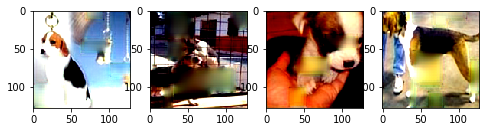

Epoch: 1


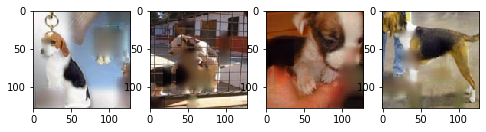

Epoch: 2


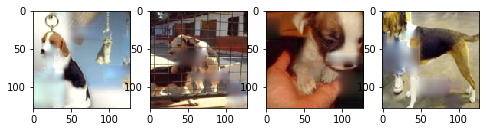

Epoch: 3


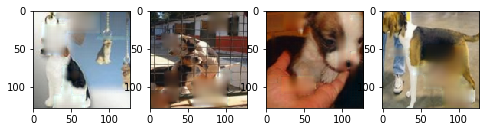

Epoch: 4


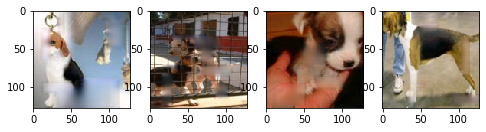

Epoch: 5


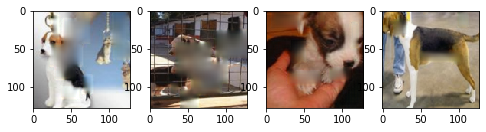

Epoch: 6


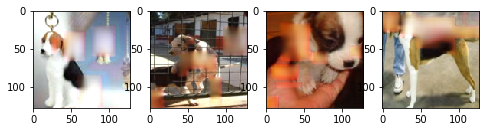

Epoch: 7


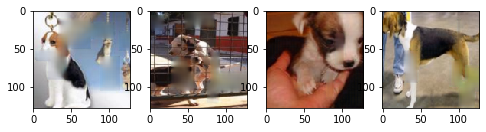

Epoch: 8


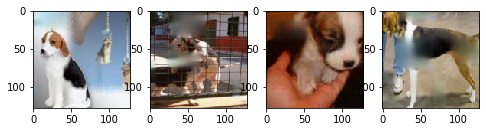

Epoch: 9


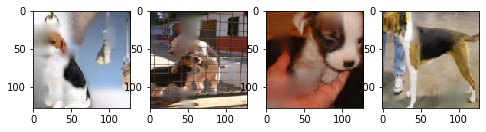

Epoch: 10


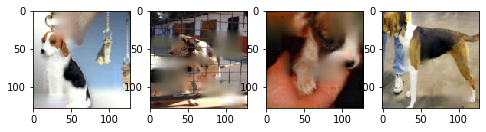

Epoch: 11


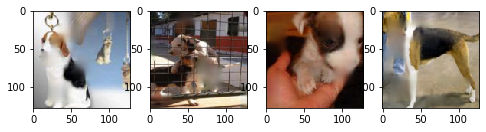

Epoch: 12


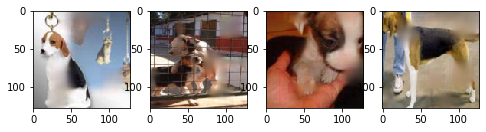

Epoch: 13


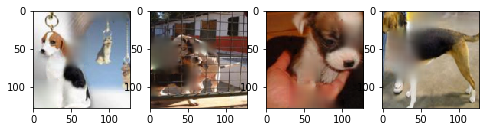

Epoch: 14


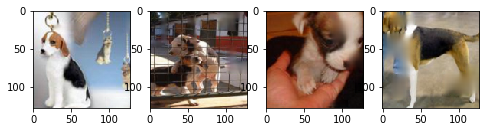

In [7]:
plotResultsCallback = PlotResultsAfterEpoch()

learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())
if fp16: learn = learn.to_fp16()
cbs = [plotResultsCallback]
learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

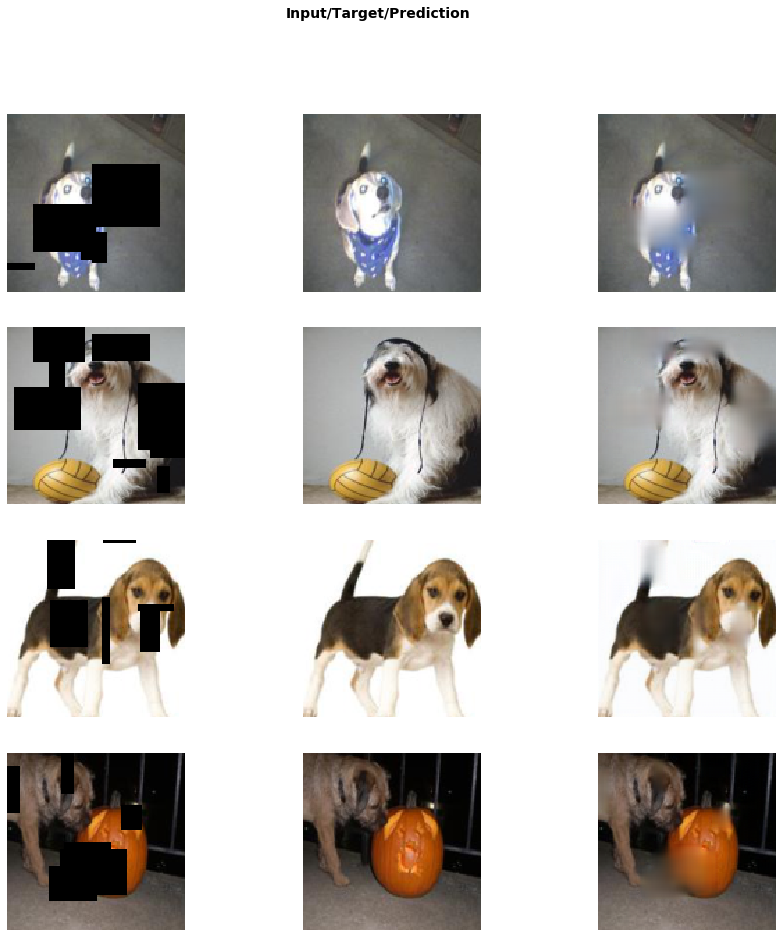

In [8]:
# Let's take a look at the output images
learn.predict(dbunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

In [9]:
# I'm not using fastai2's .export() because I only want to save 
# the model's parameters. 
torch.save(learn.model[0].state_dict(), 'imagewang_inpainting_15_epochs.pth')

Note: This approach seems to work reasonably well, but the outputs are noticably blurry. 

This [paper](https://arxiv.org/pdf/1604.07379.pdf) notes that and instead uses a combined L2 loss + adversarial loss to generate more realistic images. That said, I'm not sure if more realistic images necessarily translates into better downstream performance. For that reason, I'm not quite sure if I'd like to go down the GAN route just yet.